<a href="https://colab.research.google.com/github/bryanfree66/AIPND_image_classification/blob/master/sentiment_analysis_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Identification Work Sample
## Data Description


1.   Number of records: 20000
2.   Text data
3.   Two string data type values per record
4.   Tagged for Sentiment (Positive, Negative, Neutral)
5.   The training data includes documents from a wide variety of sources

[Dataset link](http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set)

## Goal
* Train a sentiment classifier on the corpus of the dataset 
* Maximize accuracy of the classifier
* I want to be more sensitive to identifying negative

## Plan of Work
1. Load and clean up the data
2. Do some exploratory data analysis
3. Filter out Roman Urdu stop words
4. Evaluate creating additional features
5. Vectorize reviews
6. Train and evaluate model(s)
7. Select best model based on accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")
# drive.mount('/content/drive')
train_split = .8

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the Data

In [2]:
# Use session storage
original_data = pd.read_csv('/content/data/roman_urdu/Roman Urdu DataSet.csv',
                            encoding='utf8')

# Use Google Drive
# original_data = pd.read_csv('/content/drive/My Drive/working_data/roman_urdu/Roman Urdu DataSet.csv',
#                            encoding='utf8')

# Save a clean copy for later
clean_copy = original_data.copy()  
print('Original data shape: {}'.format(original_data.shape))

Original data shape: (20228, 3)


I can see right away the dataset is not the shape I expected. The data description has two columns, but we seem to be picking up an extra column from the CSV.

### Initial Cleaning

In [3]:
original_data.head()

,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,Unnamed: 2
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN
2,Wah je wah,Positive,NaN
3,Are wha kaya bat hai,Positive,NaN
4,Wah kya baat likhi,Positive,NaN


It looks like an extra I wasn`t expecting. I´m also going to rename the first columns. I will set up a data pipeline later to automate all of the changes. 

I´ll start by renaming the columns for convenience.

In [0]:
original_data.columns = ['review','target','unexpected']
phrase_col = 'review'
target_col = 'target'

In [5]:
original_data.head()

,review,target,unexpected
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN
2,Wah je wah,Positive,NaN
3,Are wha kaya bat hai,Positive,NaN
4,Wah kya baat likhi,Positive,NaN


In [6]:
original_data.describe()

,review,target,unexpected
count,20227,20228,7
unique,19663,4,6
top,Good,Neutral,till here
freq,23,8929,2


In [7]:
original_data['unexpected'].value_counts()

till here           2
------              1
9090                1
----------          1
-------             1
----------------    1
Name: unexpected, dtype: int64

I´m going to go ahead and drop the extra column.

In [0]:
original_data.drop('unexpected', axis=1, inplace=True)

In [9]:
original_data['target'].value_counts()

Neutral     8929
Positive    6012
Negative    5286
Neative        1
Name: target, dtype: int64

We also have an unexpected value in our labels. We will have to account for that in the pipeline as well. I´m going to drop it, because I can´t automate for every spelling error in the labels.

In [10]:
correct_labels = ['Positive', 'Negative', 'Neutral']
original_data = original_data[original_data.target.isin(correct_labels)]
original_data['target'].value_counts()

Neutral     8929
Positive    6012
Negative    5286
Name: target, dtype: int64

In [11]:
original_data.isnull().sum()

review    1
target    0
dtype: int64

In [0]:
original_data.dropna(inplace=True)

There is one null review



## Duplicate Rows Check

In [13]:
print(original_data[original_data.duplicated(keep='first')])

                                                  review    target
19                                          jee ye to he  Positive
411                                             Hahahaha  Positive
585      Kabhi aap dusro k lye Dil se dua mang kr dekho   Positive
596    Karachi K Badalte Hue Halaat Or Nit Nayi Faida...  Positive
602    Aaj Bhi Shehar Me Target Killing Ka Koi Waqia ...  Positive
...                                                  ...       ...
17581  Or agr ye jhota wada howa to pti waly khud is ...  Negative
18207                              Conse colr may chaiye   Neutral
18354  Dhoka ha ye site plx mat Len ink products frau...  Negative
18363  Dhoka ha ye site plx mat Len ink products frau...  Negative
19543                                           Kia huwa   Neutral

[543 rows x 2 columns]


I'm going to drop those duplicates.

In [0]:
original_data.drop_duplicates(keep='first', inplace = True)

### TF-IDF

In [0]:
phrases = original_data[phrase_col].tolist()
phrase_labels = original_data[target_col].tolist()

Roman Urdu stopwords list from [GitHub](https://github.com/mirfan899/roman-urdu-stopwords/blob/master/stopwords.txt).

In [0]:
roman_urdo_stop_words = ['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 
                         'koi', 'ko', 'sy', 'woh' , 'bhi', 'aur', 'wo',
                         'yeh', 'rha', 'hota', 'ho', 'ga', 'ka', 'le',
                         'lye' , 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay',
                         'gya', 'gaya', 'kch', 'ab','thy', 'thay', 'houn',
                         'hain', 'han', 'to', 'is', 'hi', 'jo', 'kya', 'thi',
                         'se', 'pe', 'phr', 'wala', 'waisay', 'us', 'na',
                         'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi',
                         'uski', 'ne', 'haan', 'acha', 'nai', 'sent', 'photo',
                         'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye',
                         'ya', 'dono', 'hoa', 'aese', 'de', 'wohi', 'jati',
                         'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna',
                         'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil',
                         'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain',
                         'krny', 'tou']

In [0]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=5, max_features=16000, strip_accents='unicode',
    analyzer='word', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words=roman_urdo_stop_words)


In [18]:
tfidf_vectorizer.fit(phrases)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=16000,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha',
                            'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh',
                            'rha', 'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr',
                            'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya',
                            'gaya', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

## Data Exploration

Let´s take a look at the label distribution in our dataset

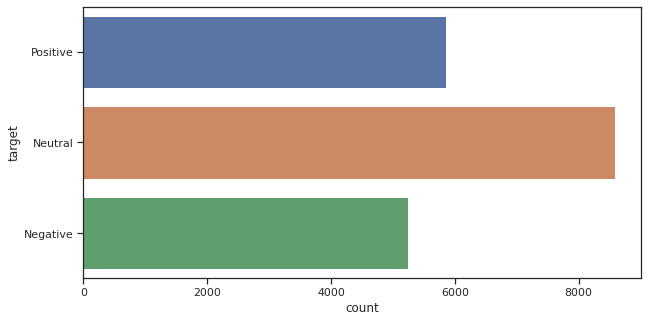

In [19]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(y=original_data.target);

It looks like we have quite a few more neutral reviews than positive and negative. The positive and negative counts are close enough.

One of the ***requirements*** of the work sample is to document how data limitations impact the result, and what I might do on a larger project.

When the class distribution is unbalanced, the model favors predicting the most frequent class. Accuracy can be a poor choice of evaluation metric for a classifier if the data is unbalanced as well.

On a larger project, I might consider a technique such as GAN minority oversampling to balance out the dataset.

The simplest way to fix imbalanced dataset is simply balancing them by oversampling instances of the minority class or undersampling instances of the majority class. That is what I will choose to do in this case.

